## Rendering Beifong

In [1]:
import os
import numpy as np
import mitsuba
import enoki as ek

# Set the desired mitsuba variant
# mitsuba.set_variant('scalar_rgb')
# mitsuba.set_variant('scalar_mono')
mitsuba.set_variant('scalar_spectral')
# mitsuba.set_variant('gpu_spectral')
# mitsuba.set_variant('gpu_rgb')
# mitsuba.set_variant('packet_spectral')

from mitsuba.core import Bitmap, Struct, Thread
from mitsuba.core.xml import load_file

from matplotlib import pyplot as plt

# Animation bits
from mitsuba.core.xml import load_dict
from mitsuba.core import Vector3f, Transform4f
from mitsuba.core import ScalarTransform4f
import matplotlib.animation as animation
from matplotlib import cm

# Geometry and Rotations
from scipy.spatial.transform import Rotation

### Simulation Setup

In [2]:
SAM = dict({
    'type': 'independent',
    'sample_count': int(2**3),
})

INTEGRATOR = dict({
    'type': 'pathlength',
})

### Transmitter Setup

In [3]:
# TX = dict({
#     'type': 'fmcw',
#     'fc': 94e9,
#     'bandwidth': 6e9,
#     'tx_power': 0.1,
#     'wrf': 2000,
#     'rise_time': 200e-6,
#     'hold_time': 50e-6,
#     'fall_time': 200e-6,
#     'wait_time': 50e-6,
# })

TX = dict({
    'type': 'fmcw',
    'fc': 40e3,
    'bandwidth': 2e3,
    'tx_power': 10e-3,
    'wrf': 10,
    'rise_time': 90e-3,
    'hold_time': 1e-6,
    'fall_time': 1e-6,
    'wait_time': 9.998e-3,
})

### Receiver Setup

In [4]:
RX = dict({
    'type': 'hdrfilm',
    'width': 400,
    'height': 400,
    'rfilter': {
        'type': 'box'
    },
})

#### Wavelength

In [5]:
C_AIR = 340
wlen_max = int(np.ceil(C_AIR/(TX['fc'] - TX['bandwidth']/2) * 1e9))
wlen_min = int(np.ceil(C_AIR/(TX['fc'] + TX['bandwidth']/2) * 1e9))

### Transmit Antenna Setup
We should also extend this and attach a signal, similar to how emitter has a film
<br> <br>
Another thought, if we were doing a phasor representation, we would still need the rms power to give to the rays. We are smarter and use wigner because it has power, time and frequency.
<br> <br>
We could extend the radiance power to include transmit antenna bandwidth considerations.

In [6]:
# Transmit Antenna/Aperture/Array
txa_size = np.array([20e-3, 50e-3, 1])
# txa_size = np.array([200e-3, 100e-3, 1])
txa_r0 = np.array([0, 0, 0.3])

# Starting orientation: z, thumb down; y, index right; x middle back
# z, boresight/up, y, right, x, forward
txa_d0_align_z = Transform4f.rotate([0,1,0], 90)
txa_d0_align_x = Transform4f.rotate([1,0,0], 90)
txa_d0 = txa_d0_align_x*txa_d0_align_z

txa_z = txa_d0.transform_vector([0,0,1])
txa_y = txa_d0.transform_vector([0,1,0])
txa_x = txa_d0.transform_vector([1,0,0])

txa_trafo = Transform4f.translate(txa_r0)*txa_d0*Transform4f.scale(txa_size)
# txa_trafo = Transform4f.translate(txa_r0)*txa_d0


TXA = dict({
    'type': 'rectangle',
    'to_world': txa_trafo,
    'emitter': {
        'type': 'wignertransmitter',
        'radiance': {
            'type': 'spectrum',
            'value': [(wlen_min, TX['tx_power']), (wlen_max, TX['tx_power'])],
        },
    },
})

# TXA = dict({
#     'type': 'spot',
#     'cutoff_angle': 25,
#     'beam_width': 20,
#     'intensity': {
#         'type': 'spectrum',
#         'value': [(wlen_min, TX['tx_power']), (wlen_max, TX['tx_power'])],
#     },
#     'to_world': txa_trafo,
# })

### Receive Antenna Setup

Getting this working needs to be the next priority so that I can dump the camera centric parameters from receiver/sensor

In [7]:
# Receive Antenna/Aperture/Array
rxa_size = np.array([20e-3, 50e-3, 1])
rxa_r0 = np.array([0, 0, 0.3])

# Starting orientation: z, thumb down; y, index right; x middle back
# z, boresight/up, y, right, x, forward
rxa_d0_align_z = Transform4f.rotate([0,1,0], 90)
rxa_d0_align_x = Transform4f.rotate([1,0,0], 90)
rxa_d0 = rxa_d0_align_x*rxa_d0_align_z

rxa_z = rxa_d0.transform_vector([0,0,1])
rxa_y = rxa_d0.transform_vector([0,1,0])
rxa_x = rxa_d0.transform_vector([1,0,0])

rxa_trafo = Transform4f.translate(rxa_r0)*rxa_d0

RXA = dict({
    'type': 'perspective',
    'to_world': rxa_trafo,
    'near_clip': 0.100000,
    'far_clip': 100.0,
    'fov_axis': 'x',
    'fov': 45.0,
    'sampler': SAM,
    'film': RX,
})


# rxa_trafo = rxa_d0*Transform4f.translate(rxa_r0)*Transform4f.scale(rxa_size)

# RXA = dict({
#     'type': 'rectangle',
#     'to_world': rxa_trafo,
#     'sensor' : {
#         'type': 'irradiancemeter',
#         'sampler': SAM,
#         'film': RXF,
#     }
# })

### Scene Geometry Setup

Note: World Origin [0, 0, 0]; Object Direction [0, 0, 1], no rotation

In [8]:
# Reflector
refl_size = np.array([100e-3, 50e-3, 1])
# refl_r0 = np.array([1, 0.5, 0.3])
refl_r0 = np.array([1, 0, 0.3])

# Starting orientation: z, thumb down; y, index right; x middle back
# z, boresight/up, y, right, x, forward
refl_d0_align_z = Transform4f.rotate([0,1,0], 90)
refl_d0_align_x = Transform4f.rotate([1,0,0], 90)
refl_d0 = refl_d0_align_x*refl_d0_align_z

refl_z = refl_d0.transform_vector([0,0,1])
refl_y = refl_d0.transform_vector([0,1,0])
refl_x = refl_d0.transform_vector([1,0,0])

refl_trafo = Transform4f.translate(refl_r0)*refl_d0*Transform4f.scale(refl_size)


# Ground
gnd_size = np.array([20, 20, 1])
gnd_r0 = np.array([0, 0, 0])
gnd_d0 = Transform4f.rotate([0,0,1], 0)

gnd_trafo = Transform4f.translate(gnd_r0)*gnd_d0*Transform4f.scale(gnd_size)


# Car
car_size = np.array([1e-3, 1e-3, 1e-3])
car_r0 = np.array([10, 3, 1])

car_d0_align_z = Transform4f.rotate([1,0,0], 90)
car_d0_align_x = Transform4f.rotate([0,0,1], -20)
car_d0 = car_d0_align_x*car_d0_align_z

car_z = car_d0.transform_vector([0,0,1])
car_y = car_d0.transform_vector([0,1,0])
car_x = car_d0.transform_vector([1,0,0])

car_trafo = Transform4f.translate(car_r0)*car_d0*Transform4f.scale(car_size)

### Object BSDFs

In [9]:
B_GND = dict({
    'type': 'twosided',
    'id': 'material',
    'bsdf': {
        'type': 'diffuse',
#         'type': 'plastic',
#         'specular_reflectance': {
        'reflectance': {
            'type': 'spectrum',
            'value': [(wlen_min, 0.5), (wlen_max, 0.5)],
        },
    },
})

B_REFL = dict({
    'type': 'twosided',
    'id': 'material',
    'bsdf': {
        'type': 'diffuse',
#         'type': 'conductor',
#         'type': 'roughconductor',
        'reflectance': {
#         'specular_reflectance': {
            'type': 'spectrum',
            'value': [(wlen_min, 1), (wlen_max, 1)],
        },
    },
})

B_CAR = dict({
    'type': 'twosided',
    'id': 'material',
    'bsdf': {
        # 'type': 'diffuse',
        # 'reflectance': {
        'type': 'roughconductor',
        # 'type': 'plastic',
        'specular_reflectance': {
            'type': 'spectrum',
            'value': [(wlen_min, 1), (wlen_max, 1)],
        },
    },
})

### Objects

In [10]:
REFL = dict({
    'type': 'rectangle',
    'to_world': refl_trafo,
    'bsdf': B_REFL,
})

GND = dict({
    'type': 'rectangle',
    'to_world': gnd_trafo,
    'bsdf': B_GND,
})

CAR = dict({
    'type': 'obj',
    'filename': './Bus.obj',
    # 'filename': './Car-body.ply',
    # 'filename': './Motorbike_ply.ply',
    'to_world': car_trafo,
    'bsdf': B_CAR,
})

### Load All Parameters into Scene

In [11]:
scene = load_dict({
    'type': 'scene',
    'integrator': INTEGRATOR,
    'sensor': RXA,
    'emitter': TXA,
    's0': REFL,
    's1': GND,
#     's2': CAR,
})

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/pathlength.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/perspective.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/independent.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/hdrfilm.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/box.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/rectangle.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/wignertransmitter.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/regular.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/d65.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/diffuse.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/uniform.so" ..

2021-01-07 17:10:48 INFO main [PluginManager] Loading plugin "plugins/twosided.so" ..

2021-01-07 17:10:48 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2021-01-07 17:10:48 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

## Render the Scene
After rendering, the rendered data is stored in the film

In [12]:
scene.integrator().render(scene, scene.sensors()[0])
# scene.integrator().receive(scene, scene.sensors()[0])

2021-01-07 17:10:50 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 24 threads)

2021-01-07 17:10:50 INFO main [SamplingIntegrator] Rendering finished. (took 54ms)

True

In [13]:
film = scene.sensors()[0].film()
bmp = film.bitmap(raw=True)
bmp_np = np.array(bmp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


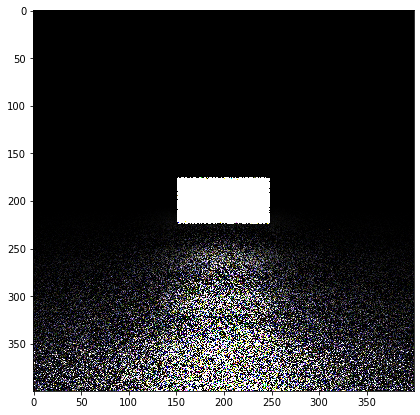

In [21]:
fig1 = plt.figure(figsize=(14, 7))
axes1 = fig1.add_subplot()

# power_max = 100*TX["tx_power"]
# mask = bmp_np[:,:,0:3]>0
# mask *= bmp_np[:,:,0:3]<power_max
# vals = 10*np.log10((bmp_np[:,:,0:3]*mask/SAM["sample_count"]) + np.finfo(float).eps)

mask = bmp_np[:,:,0:3]>0
gain = 1e4
vals = bmp_np[:,:,0:3]*mask*gain

axes1.imshow(vals, interpolation='nearest')

In [48]:
bmp_ss = bmp_np[:, :, 0:5]
bmpout = Bitmap(bmp_ss, Bitmap.PixelFormat.XYZAW)
bmpout.write('./transients/' + 'bmp_ss.exr')
bmpout.convert(Bitmap.PixelFormat.RGB, Struct.Type.UInt8, srgb_gamma=True).write('./transients/' + 'bmp_ss' + '.jpg')


In [244]:
# # Write out rendering as high dynamic range OpenEXR file
# # film.set_destination_file('./' + name + '.exr')
# # film.develop()
#
# bmp2 = film.bitmap(raw=True)
# bmp22_np = np.array(bmp2)
# print(bmp22_np.shape)
# # print(bmp22_np.tolist())
#
# # Section for images ----------------------------------------------------------
# bmp_ss = bmp22_np[:, :, 0:5]
# bmpout = Bitmap(bmp_ss, Bitmap.PixelFormat.XYZAW)
# bmpout.write('./transients/' + 'bmp_ss.exr')
# bmpout.convert(Bitmap.PixelFormat.RGB, Struct.Type.UInt8, srgb_gamma=True).write('./transients/' + 'bmp_ss' + '.jpg')

## Rotate about the origin and render

In [245]:
# Angular velocity rad/s
theta_0 = np.deg2rad(0)
omega = 2*2*np.pi
dt = 0.01
n_revs = 1

n_frames = int(np.ceil((n_revs*2*np.pi)/(omega*dt)))
t_max = n_frames*dt

# Storage
lesum = np.zeros([n_frames+1, RXR['range_bins']])

txa_new = txa_trafo
rxa_new = rxa_trafo

t = 0
i = 0
while(t<=t_max):
#     txa_d = Transform4f.rotate(txa_y, np.rad2deg(omega*dt))
#     txa_d = Transform4f.rotate(-txa_x, np.rad2deg(omega*dt))
#     txa_d = Transform4f.rotate([0,0,1], np.rad2deg(omega*dt))
    # Rotate about the y-axis of the txrx
#     txa_d = Transform4f.rotate([0,1,0], np.rad2deg(-omega)*dt)

#     txa_d = Transform4f.rotate([0,0,1], np.rad2deg(-omega)*dt)
    txa_d = Transform4f.rotate(txa_y, np.rad2deg(-omega)*dt)
    
    txa_x = txa_d.transform_vector(txa_x)
    txa_y = txa_d.transform_vector(txa_y)
    txa_z = txa_d.transform_vector(txa_z)
    txa_new = txa_d*txa_new
    
    rxa_x = txa_d.transform_vector(rxa_x)
    rxa_y = txa_d.transform_vector(rxa_y)
    rxa_z = txa_d.transform_vector(rxa_z)
    rxa_new = txa_d*rxa_new
    
    # Gotta find smarter way to update scene
    TXA = dict({
        'type': 'rectangle',
        'to_world': txa_new,
        'emitter': {
            'type': 'wignertransmitter',
            'radiance': {
                'type': 'spectrum',
                'value': [(wlen_min, TX['tx_power']), (wlen_max, TX['tx_power'])],
            },
        },
    })
    
#     TXA = dict({
#         'type': 'spot',
#         'cutoff_angle': 25,
#         'beam_width': 20,
#         'intensity': {
#             'type': 'spectrum',
#             'value': [(wlen_min, 1000), (wlen_max, 1000)],
#         },
#         'to_world': txa_new,
#     })
    
    RXA = dict({
        'type': 'perspective',
        'to_world': rxa_new,
        'near_clip': 0.100000,
        'far_clip': 100.0,
        'fov_axis': 'x',
        'fov': 45.0,
        'sampler': SAM,
        'film': RXF,
    })
    
    scene = load_dict({
        'type': 'scene',
        'integrator': INTEGRATOR,
        'sensor': RXA,
        'emitter': TXA,
        's0': REFL,
        's1': GND,
    #     's2': CAR,
    })
    
    scene.integrator().render(scene, scene.sensors()[0])
    film = scene.sensors()[0].film()
    bmp_np = np.array(film.bitmap(raw=True))
    
    for j in range(0, RXR['range_bins']):
        idx_lo = 5 + j + 2*j
        idx_hi = 5 + j+3 + 2*j
        lesum[i, j] = (sum(sum(sum(bmp_np[:, :, idx_lo:idx_hi]))))
#         print(bmp_np[:, :, idx_lo:idx_hi])
        
    i+=1
    t+=dt


2020-12-16 12:59:52 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 12:59:52 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 12:59:52 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 12:59:53 INFO main [SamplingIntegrator] Rendering finished. (took 652ms)

2020-12-16 12:59:53 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 12:59:53 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 12:59:53 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 12:59:54 INFO main [SamplingIntegrator] Rendering finished. (took 656ms)

2020-12-16 12:59:54 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 12:59:54 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 12:59:55 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 12:59:55 INFO main [SamplingIntegrator] Rendering finished. (took 654ms)

2020-12-16 12:59:56 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 12:59:56 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 12:59:56 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 12:59:57 INFO main [SamplingIntegrator] Rendering finished. (took 674ms)

2020-12-16 12:59:57 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 12:59:57 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 12:59:57 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 12:59:58 INFO main [SamplingIntegrator] Rendering finished. (took 650ms)

2020-12-16 12:59:58 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 12:59:58 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 12:59:59 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 12:59:59 INFO main [SamplingIntegrator] Rendering finished. (took 657ms)

2020-12-16 13:00:00 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:00 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:00 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:01 INFO main [SamplingIntegrator] Rendering finished. (took 653ms)

2020-12-16 13:00:01 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:01 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:01 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:02 INFO main [SamplingIntegrator] Rendering finished. (took 646ms)

2020-12-16 13:00:02 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:02 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:03 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:03 INFO main [SamplingIntegrator] Rendering finished. (took 652ms)

2020-12-16 13:00:04 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:04 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:04 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:05 INFO main [SamplingIntegrator] Rendering finished. (took 653ms)

2020-12-16 13:00:05 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:05 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:05 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:06 INFO main [SamplingIntegrator] Rendering finished. (took 696ms)

2020-12-16 13:00:06 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:06 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:07 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:07 INFO main [SamplingIntegrator] Rendering finished. (took 661ms)

2020-12-16 13:00:08 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:08 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:08 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:09 INFO main [SamplingIntegrator] Rendering finished. (took 661ms)

2020-12-16 13:00:09 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:09 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:09 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:10 INFO main [SamplingIntegrator] Rendering finished. (took 647ms)

2020-12-16 13:00:10 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:10 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:11 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:11 INFO main [SamplingIntegrator] Rendering finished. (took 649ms)

2020-12-16 13:00:12 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:12 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:12 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:13 INFO main [SamplingIntegrator] Rendering finished. (took 658ms)

2020-12-16 13:00:13 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:13 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:13 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:14 INFO main [SamplingIntegrator] Rendering finished. (took 660ms)

2020-12-16 13:00:14 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:14 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:15 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:15 INFO main [SamplingIntegrator] Rendering finished. (took 652ms)

2020-12-16 13:00:15 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:15 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:16 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:16 INFO main [SamplingIntegrator] Rendering finished. (took 645ms)

2020-12-16 13:00:17 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:17 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:17 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:18 INFO main [SamplingIntegrator] Rendering finished. (took 649ms)

2020-12-16 13:00:18 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:18 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:18 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:19 INFO main [SamplingIntegrator] Rendering finished. (took 656ms)

2020-12-16 13:00:19 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:19 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:20 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:20 INFO main [SamplingIntegrator] Rendering finished. (took 645ms)

2020-12-16 13:00:21 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:21 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:21 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:22 INFO main [SamplingIntegrator] Rendering finished. (took 655ms)

2020-12-16 13:00:22 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:22 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:22 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:23 INFO main [SamplingIntegrator] Rendering finished. (took 739ms)

2020-12-16 13:00:24 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:24 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:24 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:25 INFO main [SamplingIntegrator] Rendering finished. (took 714ms)

2020-12-16 13:00:25 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:25 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:25 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:26 INFO main [SamplingIntegrator] Rendering finished. (took 660ms)

2020-12-16 13:00:26 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:26 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:27 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:27 INFO main [SamplingIntegrator] Rendering finished. (took 681ms)

2020-12-16 13:00:28 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:28 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:28 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:29 INFO main [SamplingIntegrator] Rendering finished. (took 662ms)

2020-12-16 13:00:29 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:29 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:30 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:30 INFO main [SamplingIntegrator] Rendering finished. (took 668ms)

2020-12-16 13:00:30 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:30 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:31 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:32 INFO main [SamplingIntegrator] Rendering finished. (took 705ms)

2020-12-16 13:00:32 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:32 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:32 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:33 INFO main [SamplingIntegrator] Rendering finished. (took 672ms)

2020-12-16 13:00:33 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:33 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:34 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:34 INFO main [SamplingIntegrator] Rendering finished. (took 670ms)

2020-12-16 13:00:35 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:35 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:35 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:36 INFO main [SamplingIntegrator] Rendering finished. (took 670ms)

2020-12-16 13:00:36 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:36 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:36 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:37 INFO main [SamplingIntegrator] Rendering finished. (took 691ms)

2020-12-16 13:00:37 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:37 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:38 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:39 INFO main [SamplingIntegrator] Rendering finished. (took 713ms)

2020-12-16 13:00:39 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:39 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:39 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:40 INFO main [SamplingIntegrator] Rendering finished. (took 695ms)

2020-12-16 13:00:40 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:40 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:41 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:41 INFO main [SamplingIntegrator] Rendering finished. (took 693ms)

2020-12-16 13:00:42 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:42 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:42 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:43 INFO main [SamplingIntegrator] Rendering finished. (took 664ms)

2020-12-16 13:00:43 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:43 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:43 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:44 INFO main [SamplingIntegrator] Rendering finished. (took 661ms)

2020-12-16 13:00:44 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:44 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:45 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:45 INFO main [SamplingIntegrator] Rendering finished. (took 666ms)

2020-12-16 13:00:46 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:46 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:46 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:47 INFO main [SamplingIntegrator] Rendering finished. (took 668ms)

2020-12-16 13:00:47 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:47 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:47 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:48 INFO main [SamplingIntegrator] Rendering finished. (took 698ms)

2020-12-16 13:00:48 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:48 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:49 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:50 INFO main [SamplingIntegrator] Rendering finished. (took 688ms)

2020-12-16 13:00:50 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:50 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:50 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:51 INFO main [SamplingIntegrator] Rendering finished. (took 671ms)

2020-12-16 13:00:51 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:51 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:52 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:52 INFO main [SamplingIntegrator] Rendering finished. (took 729ms)

2020-12-16 13:00:53 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:53 INFO main [ShapeKDTree] Finished. (20 B of storage, took 0ms)

2020-12-16 13:00:53 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:54 INFO main [SamplingIntegrator] Rendering finished. (took 667ms)

2020-12-16 13:00:54 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:54 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:54 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:55 INFO main [SamplingIntegrator] Rendering finished. (took 678ms)

2020-12-16 13:00:55 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:55 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:56 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:56 INFO main [SamplingIntegrator] Rendering finished. (took 670ms)

2020-12-16 13:00:57 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:57 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:57 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:58 INFO main [SamplingIntegrator] Rendering finished. (took 659ms)

2020-12-16 13:00:58 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 13:00:58 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 13:00:58 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 13:00:59 INFO main [SamplingIntegrator] Rendering finished. (took 671ms)

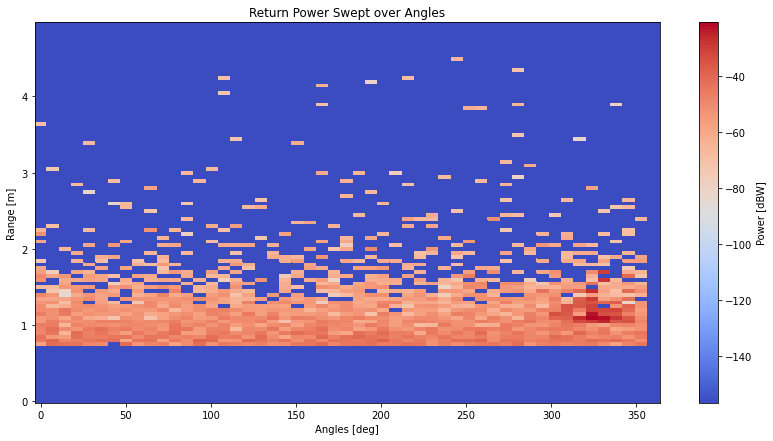

In [247]:
# Outputs
lesum_log = 10*np.log10(np.abs(lesum) + np.finfo(float).eps)
rs = np.arange(0, RXR['dr']*RXR['range_bins'], RXR['dr'])
rs = rs/2

thetas = np.arange(theta_0, theta_0 + (n_frames+1)*omega*dt, omega*dt)
rr, tt = np.meshgrid(rs, thetas)

# minc = lesum[(lesum > -140)].min()
minc = lesum_log[(lesum_log > -200)].min()
maxc = lesum_log.max()

# fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
# pol = ax.contourf(tt, rr, lesum, cmap=cm.coolwarm, vmin=minc, vmax=maxc)
# fig.colorbar(pol)

fig1 = plt.figure(figsize=(14, 7))
# axes1 = fig1.add_subplot(projection='polar')
axes1 = fig1.add_subplot()
ret = axes1.pcolormesh(np.rad2deg(tt), rr, lesum_log, cmap=cm.coolwarm, vmin=minc, vmax=maxc, shading='auto')
# ret = axes1.pcolormesh(tt, rr, lesum_log, cmap=cm.coolwarm, vmin=minc, vmax=maxc, shading='auto')
# ret = axes1.pcolormesh(lesum_log, cmap=cm.coolwarm, vmin=minc, vmax=maxc, shading='auto')
axes1.set_xlabel('Angles [deg]')
axes1.set_ylabel('Range [m]')
axes1.set_title('Return Power Swept over Angles')

cbar = fig1.colorbar(ret)
cbar.set_label('Power [dBW]')

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(rr, np.rad2deg(tt), lesum
#                        , cmap=cm.coolwarm, vmin=minc, vmax=maxc)
# fig.colorbar(surf)


# xLabel = ax.set_xlabel('Range [m]')
# yLabel = ax.set_ylabel('Angle [deg]')
# xLabel = ax.set_xlabel('X [m]')
# yLabel = ax.set_ylabel('Y [m]')
# zLabel = ax.set_zlabel('Return Value [dBW]')


In [220]:
# Angular velocity rad/s
theta_0 = np.deg2rad(0)
omega = 2*2*np.pi
dt = 0.01
n_revs = 1

n_frames = int(np.ceil((n_revs*2*np.pi)/(omega*dt)))
t_max = n_frames*dt

# Storage
lesum = np.zeros([n_frames+1, RXR['range_bins']])

txa_new = txa_trafo
rxa_new = rxa_trafo

t = 0
i = 0

2020-12-16 12:50:03 INFO main [ShapeKDTree] Building a SAH kd-tree (3 primitives) ..

2020-12-16 12:50:03 INFO main [ShapeKDTree] Finished. (20 B of storage, took 1ms)

2020-12-16 12:50:03 INFO main [SamplingIntegrator] Starting render job (400x400, 8 samples, 8 threads)

2020-12-16 12:50:04 INFO main [SamplingIntegrator] Rendering finished. (took 664ms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


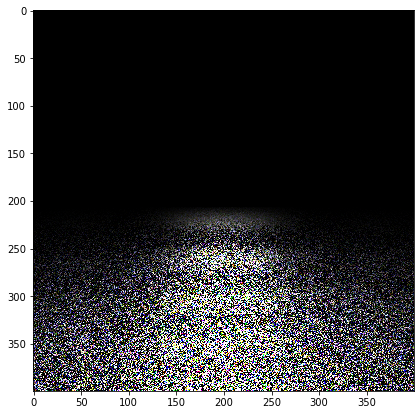

In [221]:
#     txa_d = Transform4f.rotate(txa_y, np.rad2deg(omega*dt))
#     txa_d = Transform4f.rotate(-txa_x, np.rad2deg(omega*dt))
#     txa_d = Transform4f.rotate([0,0,1], np.rad2deg(omega*dt))
# Rotate about the y-axis of the txrx
# txa_d = Transform4f.rotate([0,1,0], np.rad2deg(-omega)*dt)
txa_d = Transform4f.rotate([0,0,1], np.rad2deg(-omega)*dt)
# ??? Rotate about world z axis?

#     txa_x = txa_d.transform_vector(txa_x)
#     txa_y = txa_d.transform_vector(txa_y)
#     txa_z = txa_d.transform_vector(txa_z)
txa_new = txa_d*txa_new

#     rxa_x = txa_d.transform_vector(rxa_x)
#     rxa_y = txa_d.transform_vector(rxa_y)
#     rxa_z = txa_d.transform_vector(rxa_z)
rxa_new = txa_d*rxa_new

# Gotta find smarter way to update scene
TXA = dict({
    'type': 'rectangle',
    'to_world': txa_new,
    'emitter': {
        'type': 'wignertransmitter',
        'radiance': {
            'type': 'spectrum',
            'value': [(wlen_min, TX['tx_power']), (wlen_max, TX['tx_power'])],
        },
    },
})

#     TXA = dict({
#         'type': 'spot',
#         'cutoff_angle': 25,
#         'beam_width': 20,
#         'intensity': {
#             'type': 'spectrum',
#             'value': [(wlen_min, 1000), (wlen_max, 1000)],
#         },
#         'to_world': txa_new,
#     })

RXA = dict({
    'type': 'perspective',
    'to_world': rxa_new,
    'near_clip': 0.100000,
    'far_clip': 100.0,
    'fov_axis': 'x',
    'fov': 45.0,
    'sampler': SAM,
    'film': RXF,
})

scene = load_dict({
    'type': 'scene',
    'integrator': INTEGRATOR,
    'sensor': RXA,
    'emitter': TXA,
    's0': REFL,
    's1': GND,
#     's2': CAR,
})

scene.integrator().render(scene, scene.sensors()[0])
film = scene.sensors()[0].film()
bmp_np = np.array(film.bitmap(raw=True))
mask = bmp_np[:,:,0:3]>0
# bmp_np[:,:,0:3] = bmp_np[:,:,0:3]*mask

fig1 = plt.figure(figsize=(14, 7))
axes1 = fig1.add_subplot()

axes1.imshow(bmp_np[:,:,0:3]*mask, interpolation='nearest')

for j in range(0, RXR['range_bins']):
    idx_lo = 5 + j + 2*j
    idx_hi = 5 + j+3 + 2*j
    lesum[i, j] = (sum(sum(sum(bmp_np[:, :, idx_lo:idx_hi]))))
#         print(bmp_np[:, :, idx_lo:idx_hi])

i+=1
t+=dt